## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import torch.nn as nn
import numpy as np
import time

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@ExactParametrizedFunctions()
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticExact"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(2., 4.0), (2., 4.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-8)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(500)
reduced_problem = reduction_method.offline()

=           NonlinearEllipticExact POD-Galerkin offline phase begins           =

###################################### 0 #######################################
truth solve for mu = (3.0976270078546495, 3.430378732744839)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.060527e-01
  2 SNES Function norm 4.505075e-02
  3 SNES Function norm 1.034704e-03
  4 SNES Function norm 5.461005e-07
  5 SNES Function norm 1.529526e-13
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (3.205526752143288, 3.0897663659937935)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.329051e-01
  2 SNES Function norm 2.546900e-02
  3 SNES Function norm 3.013750e-04
  4 SNES Function norm 4.186991e-08
  5 SNES Function norm 4.353149e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##########

  3 SNES Function norm 1.162531e-04
  4 SNES Function norm 6.157672e-09
  5 SNES Function norm 4.204943e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 18 ######################################
truth solve for mu = (3.224191445444843, 3.233867993749514)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.659557e-01
  2 SNES Function norm 3.367597e-02
  3 SNES Function norm 5.507934e-04
  4 SNES Function norm 1.466398e-07
  5 SNES Function norm 1.135525e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 19 ######################################
truth solve for mu = (3.8874961570292483, 3.363640598206967)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.485474e-01
  2 SNES Function norm 5.509762e-02
  3 SNES Function norm 1.521532e-03
  4 SNES Function norm 1.170281e-06
  5 SNES Function nor

  3 SNES Function norm 9.112618e-04
  4 SNES Function norm 4.036764e-07
  5 SNES Function norm 7.976899e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 37 ######################################
truth solve for mu = (3.478527158796603, 2.0783755845086413)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.007223e-01
  2 SNES Function norm 3.009481e-03
  3 SNES Function norm 2.629292e-06
  4 SNES Function norm 2.018833e-12
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

###################################### 38 ######################################
truth solve for mu = (2.565613925152819, 2.2403931224263376)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.917687e-02
  2 SNES Function norm 2.445759e-03
  3 SNES Function norm 1.727903e-06
  4 SNES Function norm 8.613834e-13
PETSc SNES solver converged in 4 iterations with converg

  2 SNES Function norm 6.359430e-02
  3 SNES Function norm 2.168391e-03
  4 SNES Function norm 2.551138e-06
  5 SNES Function norm 3.556526e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 56 ######################################
truth solve for mu = (3.3989585506350086, 2.594873901710267)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.577427e-01
  2 SNES Function norm 1.007400e-02
  3 SNES Function norm 3.896001e-05
  4 SNES Function norm 5.788905e-10
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

###################################### 57 ######################################
truth solve for mu = (3.627595639404954, 2.793011481693969)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.989472e-01
  2 SNES Function norm 1.723315e-02
  3 SNES Function norm 1.256131e-04
  4 SNES Function norm 6.626452e-09
  5 SNES Function nor

update snapshots matrix

###################################### 74 ######################################
truth solve for mu = (3.428482599098223, 3.997694013135733)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 5.520336e-01
  2 SNES Function norm 1.245588e-01
  3 SNES Function norm 8.329260e-03
  4 SNES Function norm 3.952527e-05
  5 SNES Function norm 9.034343e-10
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 75 ######################################
truth solve for mu = (2.2988966093159875, 3.7362521147364287)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.111694e-01
  2 SNES Function norm 4.936910e-02
  3 SNES Function norm 1.325309e-03
  4 SNES Function norm 9.560370e-07
  5 SNES Function norm 5.001221e-13
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 76 #########################

  3 SNES Function norm 9.179478e-04
  4 SNES Function norm 4.112633e-07
  5 SNES Function norm 8.313664e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 93 ######################################
truth solve for mu = (3.0712656060499164, 3.179819952709142)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.432031e-01
  2 SNES Function norm 2.826819e-02
  3 SNES Function norm 3.808310e-04
  4 SNES Function norm 6.860454e-08
  5 SNES Function norm 4.877373e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 94 ######################################
truth solve for mu = (3.4602440590335393, 2.6238899909592037)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.643988e-01
  2 SNES Function norm 1.109005e-02
  3 SNES Function norm 4.802844e-05
  4 SNES Function norm 8.947606e-10
PETSc SNES solver c

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.999793e-01
  2 SNES Function norm 4.513527e-02
  3 SNES Function norm 1.076071e-03
  4 SNES Function norm 6.110156e-07
  5 SNES Function norm 1.980139e-13
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 112 ######################################
truth solve for mu = (2.371271888611904, 3.905583313943889)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.725808e-01
  2 SNES Function norm 6.819874e-02
  3 SNES Function norm 2.596300e-03
  4 SNES Function norm 3.817466e-06
  5 SNES Function norm 8.315682e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 113 ######################################
truth solve for mu = (3.374976552775631, 2.431015354227117)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.353346e-01
  2 SNES Function norm


##################################### 130 ######################################
truth solve for mu = (2.481657559830894, 2.2005878845309956)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.340815e-02
  2 SNES Function norm 2.048145e-03
  3 SNES Function norm 1.164141e-06
  4 SNES Function norm 3.759761e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 131 ######################################
truth solve for mu = (2.032859259182948, 3.859058633584381)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.119981e-01
  2 SNES Function norm 5.073265e-02
  3 SNES Function norm 1.434222e-03
  4 SNES Function norm 1.147750e-06
  5 SNES Function norm 7.389540e-13
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 132 ######################################
truth solve for mu = (3.33983309318182, 3.57030

  3 SNES Function norm 1.107640e-03
  4 SNES Function norm 6.641469e-07
  5 SNES Function norm 2.399316e-13
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 149 ######################################
truth solve for mu = (3.9458389780462606, 3.9216693161260006)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 5.772565e-01
  2 SNES Function norm 1.312006e-01
  3 SNES Function norm 9.026452e-03
  4 SNES Function norm 4.557330e-05
  5 SNES Function norm 1.180016e-09
  6 SNES Function norm 3.965944e-15
PETSc SNES solver converged in 6 iterations with convergence reason 2.
update snapshots matrix

##################################### 150 ######################################
truth solve for mu = (3.813110998442358, 3.5480946653972776)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 4.036519e-01
  2 SNES Function norm 7.246743e-02
  3 SNES Function norm 2.712120e-03
  4 SNES Function n

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.836730e-01
  2 SNES Function norm 6.700095e-02
  3 SNES Function norm 2.331731e-03
  4 SNES Function norm 2.868124e-06
  5 SNES Function norm 4.373313e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 168 ######################################
truth solve for mu = (2.51884512869071, 2.747626275865123)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.389858e-01
  2 SNES Function norm 8.163815e-03
  3 SNES Function norm 2.578251e-05
  4 SNES Function norm 2.542879e-10
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 169 ######################################
truth solve for mu = (3.175199270392778, 2.5456438048489343)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.422627e-01
  2 SNES Function norm 7.957045e-03
  3 SNES Function norm


##################################### 186 ######################################
truth solve for mu = (3.5135572854737784, 3.2721221108942826)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.957725e-01
  2 SNES Function norm 4.093668e-02
  3 SNES Function norm 8.242905e-04
  4 SNES Function norm 3.340745e-07
  5 SNES Function norm 5.534210e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 187 ######################################
truth solve for mu = (2.480040546759419, 2.321077644970513)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 9.313226e-02
  2 SNES Function norm 2.808660e-03
  3 SNES Function norm 2.372273e-06
  4 SNES Function norm 1.686511e-12
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 188 ######################################
truth solve for mu = (3.5927829490346634, 3.91

  3 SNES Function norm 1.755399e-06
  4 SNES Function norm 8.697560e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 205 ######################################
truth solve for mu = (2.0312121288936567, 2.8575914449964754)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.263602e-01
  2 SNES Function norm 6.909867e-03
  3 SNES Function norm 1.848784e-05
  4 SNES Function norm 1.305143e-10
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 206 ######################################
truth solve for mu = (2.1361481479494406, 2.5038819764921856)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 9.606742e-02
  2 SNES Function norm 3.263217e-03
  3 SNES Function norm 3.408552e-06
  4 SNES Function norm 3.687864e-12
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots ma

  1 SNES Function norm 5.644160e-01
  2 SNES Function norm 1.280350e-01
  3 SNES Function norm 8.716810e-03
  4 SNES Function norm 4.299306e-05
  5 SNES Function norm 1.062038e-09
  6 SNES Function norm 3.991115e-15
PETSc SNES solver converged in 6 iterations with convergence reason 2.
update snapshots matrix

##################################### 224 ######################################
truth solve for mu = (3.9379434093407033, 3.809896691099854)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 5.220093e-01
  2 SNES Function norm 1.117562e-01
  3 SNES Function norm 6.551985e-03
  4 SNES Function norm 2.365497e-05
  5 SNES Function norm 3.123549e-10
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 225 ######################################
truth solve for mu = (2.5931125301280598, 3.984022486828948)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 4.320328e-01
  2 SNES Function no

truth solve for mu = (2.262578656946512, 3.2082356080417638)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.908619e-01
  2 SNES Function norm 1.804233e-02
  3 SNES Function norm 1.514949e-04
  4 SNES Function norm 1.053376e-08
  5 SNES Function norm 4.352651e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 243 ######################################
truth solve for mu = (2.765616118315708, 3.7907717685764197)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.834857e-01
  2 SNES Function norm 6.998676e-02
  3 SNES Function norm 2.668658e-03
  4 SNES Function norm 3.943705e-06
  5 SNES Function norm 8.680269e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 244 ######################################
truth solve for mu = (3.9355893435970035, 3.0937698033388443)
  0 SNES Function norm 1.51061

  4 SNES Function norm 1.968595e-10
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 261 ######################################
truth solve for mu = (2.060470516011965, 3.4206736579484267)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.124515e-01
  2 SNES Function norm 2.341333e-02
  3 SNES Function norm 2.722191e-04
  4 SNES Function norm 3.630745e-08
  5 SNES Function norm 4.341161e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 262 ######################################
truth solve for mu = (2.0157682070168805, 2.745358139641991)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.133970e-01
  2 SNES Function norm 5.229210e-03
  3 SNES Function norm 9.929143e-06
  4 SNES Function norm 3.534691e-11
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matr

  4 SNES Function norm 7.898403e-06
  5 SNES Function norm 3.472942e-11
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 280 ######################################
truth solve for mu = (3.237652336482753, 2.266922941869869)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.124601e-01
  2 SNES Function norm 4.228810e-03
  3 SNES Function norm 5.692755e-06
  4 SNES Function norm 1.031190e-11
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 281 ######################################
truth solve for mu = (3.9611602655745646, 3.743571469510986)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 4.945841e-01
  2 SNES Function norm 1.021805e-01
  3 SNES Function norm 5.460837e-03
  4 SNES Function norm 1.626198e-05
  5 SNES Function norm 1.459151e-10
PETSc SNES solver converged in 5 iterations with converge

truth solve for mu = (2.7243781178787785, 2.941297898427819)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.772156e-01
  2 SNES Function norm 1.439904e-02
  3 SNES Function norm 8.921414e-05
  4 SNES Function norm 3.385039e-09
  5 SNES Function norm 3.988541e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 299 ######################################
truth solve for mu = (2.7564903498469233, 3.9590538586709174)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 4.449387e-01
  2 SNES Function norm 9.042162e-02
  3 SNES Function norm 4.526030e-03
  4 SNES Function norm 1.170801e-05
  5 SNES Function norm 7.916375e-11
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 300 ######################################
truth solve for mu = (2.3493167707900113, 2.6559760018161596)
  0 SNES Function norm 1.5106

update snapshots matrix

##################################### 317 ######################################
truth solve for mu = (3.546167108109743, 3.917481846113186)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 5.281049e-01
  2 SNES Function norm 1.155686e-01
  3 SNES Function norm 7.132376e-03
  4 SNES Function norm 2.861929e-05
  5 SNES Function norm 4.670994e-10
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 318 ######################################
truth solve for mu = (2.234640960769622, 2.214008280387583)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 7.674516e-02
  2 SNES Function norm 1.686116e-03
  3 SNES Function norm 7.621257e-07
  4 SNES Function norm 1.555981e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 319 ######################################
truth solve for mu = (3.

  2 SNES Function norm 1.280157e-02
  3 SNES Function norm 6.851270e-05
  4 SNES Function norm 1.940760e-09
  5 SNES Function norm 4.176414e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 336 ######################################
truth solve for mu = (3.2290553996206413, 2.1400843802892893)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 9.987074e-02
  2 SNES Function norm 3.040883e-03
  3 SNES Function norm 2.721356e-06
  4 SNES Function norm 2.186825e-12
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 337 ######################################
truth solve for mu = (3.6448134767113807, 3.306842322227274)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.144268e-01
  2 SNES Function norm 4.581718e-02
  3 SNES Function norm 1.041191e-03
  4 SNES Function norm 5.390710e-07
  5 SNES Function n

  1 SNES Function norm 2.849006e-01
  2 SNES Function norm 4.232288e-02
  3 SNES Function norm 9.685463e-04
  4 SNES Function norm 5.052784e-07
  5 SNES Function norm 1.381824e-13
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 355 ######################################
truth solve for mu = (2.3242405214176665, 3.119364811646896)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.805263e-01
  2 SNES Function norm 1.577015e-02
  3 SNES Function norm 1.121999e-04
  4 SNES Function norm 5.601429e-09
  5 SNES Function norm 4.383164e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 356 ######################################
truth solve for mu = (3.546911088898061, 2.912819130678133)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.170338e-01
  2 SNES Function norm 2.117150e-02
  3 SNES Function nor

update snapshots matrix

##################################### 373 ######################################
truth solve for mu = (3.763793006193665, 3.439240315684576)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.628348e-01
  2 SNES Function norm 5.981451e-02
  3 SNES Function norm 1.819744e-03
  4 SNES Function norm 1.703224e-06
  5 SNES Function norm 1.502850e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 374 ######################################
truth solve for mu = (3.932779942875787, 3.0152710944815295)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.590344e-01
  2 SNES Function norm 3.026127e-02
  3 SNES Function norm 4.215689e-04
  4 SNES Function norm 8.153126e-08
  5 SNES Function norm 5.176072e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 375 ##########################

  2 SNES Function norm 7.966314e-02
  3 SNES Function norm 3.320228e-03
  4 SNES Function norm 5.911265e-06
  5 SNES Function norm 1.890895e-11
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 392 ######################################
truth solve for mu = (2.2048275169048326, 2.312766697735926)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.303611e-02
  2 SNES Function norm 2.132519e-03
  3 SNES Function norm 1.298919e-06
  4 SNES Function norm 4.799540e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 393 ######################################
truth solve for mu = (2.608397383198816, 2.1507181381666807)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.332314e-02
  2 SNES Function norm 1.995714e-03
  3 SNES Function norm 1.089802e-06
  4 SNES Function norm 3.255264e-13
PETSc SNES solver co

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.158898e-02
  2 SNES Function norm 1.762736e-03
  3 SNES Function norm 8.084814e-07
  4 SNES Function norm 1.714434e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 411 ######################################
truth solve for mu = (2.850803450710109, 2.127107549672317)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.831458e-02
  2 SNES Function norm 2.266481e-03
  3 SNES Function norm 1.432591e-06
  4 SNES Function norm 5.740277e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 412 ######################################
truth solve for mu = (2.4165065042429674, 3.864787877920989)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.650218e-01
  2 SNES Function norm 6.556435e-02
  3 SNES Function norm 2.384267e-03
  4 SNES Function nor

update snapshots matrix

##################################### 429 ######################################
truth solve for mu = (2.280632035846839, 2.717990556679264)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.237683e-01
  2 SNES Function norm 6.284472e-03
  3 SNES Function norm 1.465123e-05
  4 SNES Function norm 7.871548e-11
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 430 ######################################
truth solve for mu = (3.8742340838810354, 3.8466106151174166)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 5.323170e-01
  2 SNES Function norm 1.156228e-01
  3 SNES Function norm 7.035072e-03
  4 SNES Function norm 2.743959e-05
  5 SNES Function norm 4.231094e-10
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 431 ######################################
truth solve for mu = (

  3 SNES Function norm 2.105194e-04
  4 SNES Function norm 1.979185e-08
  5 SNES Function norm 4.456686e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 448 ######################################
truth solve for mu = (3.733577086518191, 3.255469512390569)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.065477e-01
  2 SNES Function norm 4.334050e-02
  3 SNES Function norm 9.208052e-04
  4 SNES Function norm 4.162668e-07
  5 SNES Function norm 8.564860e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 449 ######################################
truth solve for mu = (2.80285589861104, 2.833383513817422)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.650015e-01
  2 SNES Function norm 1.203292e-02
  3 SNES Function norm 5.974307e-05
  4 SNES Function norm 1.456746e-09
  5 SNES Function norm 

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.890815e-02
  2 SNES Function norm 2.382930e-03
  3 SNES Function norm 1.619897e-06
  4 SNES Function norm 7.488468e-13
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 467 ######################################
truth solve for mu = (2.9511782341696877, 3.6400448717395033)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.540716e-01
  2 SNES Function norm 5.992677e-02
  3 SNES Function norm 1.908108e-03
  4 SNES Function norm 1.952885e-06
  5 SNES Function norm 2.059586e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 468 ######################################
truth solve for mu = (2.5963747193261284, 2.301869794622083)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 9.537779e-02
  2 SNES Function norm 2.944302e-03
  3 SNES Function n


##################################### 485 ######################################
truth solve for mu = (3.469627549261122, 2.3529987777781205)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.291977e-01
  2 SNES Function norm 5.974152e-03
  3 SNES Function norm 1.216927e-05
  4 SNES Function norm 5.038941e-11
PETSc SNES solver converged in 4 iterations with convergence reason 2.
update snapshots matrix

##################################### 486 ######################################
truth solve for mu = (3.878321818174741, 3.012624448046777)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.554615e-01
  2 SNES Function norm 2.949154e-02
  3 SNES Function norm 3.997643e-04
  4 SNES Function norm 7.316653e-08
  5 SNES Function norm 4.591387e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

##################################### 487 ######################################
truth solve for mu = (3.9996171562339304, 2.394

In [8]:
class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 80)
        self.fc2 = nn.Linear(80, 80)
        self.fc3 = nn.Linear(80, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x
    
class Net2(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(in_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

In [9]:
# Step 1
# Get nonlinear_terms, parameters, N0
nonlinear_terms = np.zeros((len(reduction_method.training_set), len(reduction_method.training_set), reduced_problem.N))
params = np.array(reduction_method.training_set)
N0 = lambda sol, param_idx: 0 # N0 identically 0

solutions = []
Basis_Matrix = np.array([v.vector()[:] for v in reduced_problem.basis_functions])

for mu in reduction_method.training_set:
    problem.set_mu(mu)
    solution = problem.solve()
    solutions.append(np.array(problem._solution.vector()[:]))

for i, mu in enumerate(reduction_method.training_set):
    problem.set_mu(mu)
    operator_form = problem.assemble_operator('c')[0]
    theta = problem.compute_theta('c')
    
    for j, solution in enumerate(solutions):
        problem._solution.vector()[:] = solution
        nonlinear_terms[i, j] = (theta * Basis_Matrix @ np.array(assemble(operator_form)[:]).reshape(-1, 1)).reshape(-1)
        
solutions_ = []
for sol in solutions:
    F = Function(V)
    F.vector()[:] = sol
    solutions_.append(np.array(reduced_problem.project(F).vector()[:]))
solutions = solutions_

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

In [19]:
chosen_parameter_indices = []
fixed_mu_networks = []

# Step 2
# 2a. Set mu_1
errors = np.zeros(params.shape[0])
for i, mu_i in enumerate(params):
    # compute error
    s = 0
    for j, mu_j in enumerate(params):
        s += np.sum((nonlinear_terms[i, j] - N0(solutions[j], i))**2)
    errors[i] = s / params.shape[0]

mu_1_idx = np.argmax(errors)
mu_1 = params[mu_1_idx]
chosen_parameter_indices.append(mu_1_idx)
print("max error:", np.max(errors))
print("mu_1 index:", mu_1_idx)

# 2b. Train Network_{mu_1}(u) to approximate Nonlinearity(u; mu_1)
print("\nTraining network to approximate nonlinearity...")
Network_mu_1 = Net(reduced_problem.N, reduced_problem.N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)

x_data = torch.tensor(np.array(solutions)).float()
y_data = torch.tensor(nonlinear_terms[mu_1_idx] / np.linalg.norm(nonlinear_terms[mu_1_idx])).float()

for epoch in range(25000):
    optimizer.zero_grad()
    output = Network_mu_1(x_data)
    loss = criterion(output, y_data)
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()

Network_mu_1.eval()
fixed_mu_networks.append(Network_mu_1)

# 2c. Find theta_1_1(mu)
print("\nFinding theta...")
thetas = np.zeros((params.shape[0], 1))
for i, mu_i in enumerate(params):
    numerator = 0
    denominator = 0
    for j, mu_j in enumerate(params):
        net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
        numerator += np.dot(nonlinear_terms[i, j], net_u_mu)
        denominator += np.dot(net_u_mu, net_u_mu)
        
    theta_1_1_i = numerator / denominator
    thetas[i] = theta_1_1_i
    print(thetas[i])

max error: 2.1221437266642087
mu_1 index: 210

Training network to approximate nonlinearity...
0 0.12490848451852798
100 3.1151760140346596e-06
200 1.744331967756807e-07
300 1.2647562641632248e-07
400 9.696346836562952e-08
500 7.804622015328277e-08
600 6.607761804389156e-08
700 5.8461100849172e-08
800 5.347520470877498e-08
900 5.005215797382334e-08
1000 4.756278215722887e-08
1100 4.5652527091988304e-08
1200 4.412851950519325e-08
1300 4.2878177453076205e-08
1400 4.183718971262351e-08
1500 4.096219186067174e-08
1600 4.022167132688992e-08
1700 3.959085859150946e-08
1800 3.598879266064614e-05
1900 3.955204874728224e-08
2000 3.805380899279953e-08
2100 6.967417931491582e-08
2200 5.445038553375525e-08
2300 3.679302551518049e-08
2400 3.6536544456566844e-08
2500 3.7765516026411206e-05
2600 3.849305230119171e-08
2700 5.6753915345097994e-08
2800 3.756795763365517e-08
2900 7.256137735112134e-08
3000 7.306223892555863e-07
3100 3.5395995467979446e-08
3200 8.208208157611807e-08
3300 8.640483315502934

[23.71738184]
[26.83817649]
[7.39988455]
[10.10206583]
[7.73413069]
[5.85037355]
[11.14514578]
[20.07861437]
[8.44049466]
[11.7454745]
[9.96453211]
[19.32352826]
[14.88825938]
[11.94312313]
[8.54354074]
[18.08489199]
[14.91429949]
[7.90829684]
[8.47010107]
[14.53422672]
[8.12160534]
[5.28996662]
[13.7645568]
[22.01187317]
[0.00194399]
[10.8306686]
[12.23499372]
[9.9330709]
[20.89900793]
[22.6185503]
[16.06101359]
[18.27711437]
[10.38072653]
[22.54047849]
[7.69361127]
[7.46401998]
[9.55254547]
[11.39977172]
[12.33877465]
[10.2094354]
[8.45543961]
[13.11805985]
[9.26819733]
[9.78661605]
[20.56144961]
[20.90136671]
[10.0169044]
[14.94741055]
[13.22542016]
[6.65998524]
[15.19839158]
[20.71469538]
[12.37262327]
[9.06804603]
[27.59533259]
[20.86751211]
[18.90091794]
[24.51961144]
[22.68703659]
[17.41102937]
[7.83891127]
[7.65128928]
[16.7413712]
[15.44459549]
[7.66995645]
[10.872374]
[9.39497149]
[15.03844338]
[-0.46804833]
[23.31650962]
[6.99554059]
[8.8308473]
[5.75228466]
[8.34309272]
[10

In [20]:
matrices = []
maximum_error = np.max(errors)
mean_errors = 1

mean_errors_list = []
mean_errors_list_all = []

#while np.mean(mean_errors) > 0.0005:
for iteration in range(5):
    # Step 3
    # 3a. Set mu_2
    N1 = lambda sol, param_idx: sum([
        thetas[param_idx][i] * net(torch.tensor(sol).float().view(1, -1)).detach().numpy().reshape(-1)\
        for i, net in enumerate(fixed_mu_networks)
    ])
    
    

    errors = np.zeros(params.shape[0])
    for i, mu_i in enumerate(params):
        # compute error
        s = 0
        for j, mu_j in enumerate(params):
            s += np.sum((nonlinear_terms[i, j] - N1(solutions[j], i))**2)
        errors[i] = s / params.shape[0]
        
    mean_errors = np.zeros(params.shape[0])
    for i, mu_i in enumerate(params):
        mean_errors[i] = np.linalg.norm(nonlinear_terms[i, i] - N1(solutions[i], i)) / np.linalg.norm(nonlinear_terms[i, i])
    
    mean_errors_all = np.zeros(params.shape[0])
    for i, mu_i in enumerate(params):
        for j, mu_j in enumerate(params):
            mean_errors_all[i] += np.linalg.norm(nonlinear_terms[i, j] - N1(solutions[j], i)) / np.linalg.norm(nonlinear_terms[i, j])
        mean_errors_all[i] /= params.shape[0]
        
    print("max error:", np.max(errors))
    errors[np.array(chosen_parameter_indices)] = -1 # don't choose already chosen parameters again
    mu_2_idx = np.argmax(errors)
    mu_2 = params[mu_1_idx]
    chosen_parameter_indices.append(mu_2_idx)
    
    maximum_error = np.max(errors)
    print("mean error:", np.mean(mean_errors))
    mean_errors_list.append(np.mean(mean_errors))
    print("mean error all:", np.mean(mean_errors_all))
    mean_errors_list_all.append(np.mean(mean_errors_all))
    print("mu_2 index:", mu_2_idx)

    # 3b. Train Network_{mu_2}(u) to approximate Nonlinearity(u; mu_2)
    print("\nTraining network to approximate nonlinearity...")
    Network_mu_2 = Net(reduced_problem.N, reduced_problem.N)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)

    
    
    # need to do Gram-Schmidt on this matrix
    y_data = nonlinear_terms[mu_2_idx]
    
    for net in fixed_mu_networks:
        # form matrix of evaluations for this network
        previous_net_matrix = np.zeros((params.shape[0], nonlinear_terms.shape[2]))
        for i, mu_i in enumerate(params):
            previous_net_matrix[i] = net(torch.tensor(solutions[i]).float().view(1, -1)).detach().numpy().reshape(-1)
        
        # subtract out projection of y_data onto previous_net_matrix from y_data
        y_data -= np.sum(y_data * previous_net_matrix) / np.linalg.norm(previous_net_matrix) * previous_net_matrix
    
    y_data = torch.tensor(y_data / np.linalg.norm(y_data)).float()
    
    
    

    for epoch in range(25000):
        optimizer.zero_grad()
        output = Network_mu_2(x_data)
        loss = criterion(output, y_data)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()

    Network_mu_2.eval()
    fixed_mu_networks.append(Network_mu_2)

    # 3c. Find theta_1_2(mu), theta_2_2(mu)
    print("\nFinding theta...")
    num_nets = len(fixed_mu_networks)
    thetas = np.zeros((params.shape[0], num_nets))
    for i, mu_i in enumerate(params):
        LHS_numerator = np.zeros((num_nets, num_nets))
        LHS_denominator = np.zeros((num_nets, num_nets))
        RHS_numerator = np.zeros((num_nets, 1))
        RHS_denominator = np.zeros((num_nets, 1))

        for j, mu_j in enumerate(params):
            nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in fixed_mu_networks]

            for k1 in range(num_nets):
                RHS_numerator[k1] += np.dot(nonlinear_terms[i, j], nets_u_mu[k1])
                RHS_denominator[k1] += np.dot(nets_u_mu[k1], nets_u_mu[k1])
                for k2 in range(num_nets):
                    
                    LHS_numerator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k2])
                    LHS_denominator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k1])



        LHS = LHS_numerator / LHS_denominator
        RHS = RHS_numerator / RHS_denominator
        print(np.linalg.cond(LHS))
        matrices.append(LHS)
        thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        #print(thetas[i])

max error: 0.010234340426301844
mean error: 0.10244373464587511
mean error all: 0.10958162688891121
mu_2 index: 272

Training network to approximate nonlinearity...
0 0.05231200531125069
100 2.8796494007110596e-06
200 1.0136152468476212e-06
300 8.225563306041295e-07
400 6.77949060445826e-07
500 5.650068146678677e-07
600 4.743022543607367e-07
700 3.9934170104061195e-07
800 3.3594596970942803e-07
900 2.8158569875813555e-07
1000 3.3692839451759937e-07
1100 1.9701309383890475e-07
1200 5.197013592805888e-07
1300 1.376011908860164e-07
1400 5.756996870331932e-07
1500 1.0383635640209832e-07
1600 4.135150902584428e-06
1700 7.496338838564043e-08
1800 3.557035233825445e-05
1900 6.314448341981915e-07
2000 5.357555465934638e-08
2100 4.55516584452198e-08
2200 3.1461232197216304e-07
2300 5.347499154595425e-06
2400 2.7041671728511574e-06
2500 3.86787881723194e-08
2600 1.6098857713586767e-06
2700 6.822501745773479e-07
2800 2.064905402221484e-07
2900 3.323823693790473e-05
3000 1.5664161765016615e-05
310

1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193

1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
1.0152657193065062
max error: 0.0006784215123027507
mean error: 0.04015347299317112
mean error all: 0.04148237827622715
mu_2 index: 284

Training network to approximate nonlinearity...
0 0.07189927995204926
100 2.1791040126117878e-05
200 1.4656235180154908e-05
300 1.4299414942797739e-05
400 1.4171740986057557e-05
500 1.4049783203518018e-05
600 1.3930476598034147e-05
700 1.3813152691000141e-05
800 1.3699754163098987e-05
900 1.3586721252067946e-05
1000 1.405728926329175e-05
1100 1.3376783499552403e-05
1200 1.3264150766190141e-05
1300 2.8789183488697745e-05
1400 1.3063523510936648e-05
1500 7.679056579945609e-05
1600 1.2885753676528111e-05
1700 1.2868115845776629e-05
1800 1.271372184419306e-05
1900 1.2799290743714664e-05
2000 1.258563861483708e-05
2100 1.24963107737

6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365

6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
6.2895841365536125
max error: 0.00028968064856636273
mean error: 0.029187788967473153
mean error all: 0.030662990517005866
mu_2 index: 36

Training network to approximate nonlinearity...
0 0.032502997666597366
100 2.3021430024527945e-05
200 2.1023932276875712e-05
300 2.012423829000909e-05
400 2.132077861460857e-05
500 1.8567599909147248e-05
600 1.7831138393376023e-05
700 1.7270349417231046e-05
800 1.6518630218342878e-05
900 1.5817879102542065e-05
1000 1.5087946849234868e-05
1100 1.4550099876942113e-05

6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.80704741638518
6.807047416385

200 0.0002123835583915934
300 0.00021105057385284454
400 0.00020963473070878536
500 0.00020815325842704624
600 0.00020648495410569012
700 0.00020570041669998318
800 0.00020256979041732848
900 0.0002794144966173917
1000 0.00019778824935201555
1100 0.00019597908249124885
1200 0.0002379818179178983
1300 0.0001930632279254496
1400 0.00032779533648863435
1500 0.00022705151059199125
1600 0.0001856187591329217
1700 0.00018430162162985653
1800 0.00018293016182724386
1900 0.000185544224223122
2000 0.00017860540538094938
2100 0.00019321069703437388
2200 0.00017417145136278123
2300 0.00017628214845899493
2400 0.00016859479364939034
2500 0.0001657968678046018
2600 0.0007303406018763781
2700 0.00015820558473933488
2800 0.00015148791135288775
2900 0.0001531219168100506
3000 0.0001454659941373393
3100 0.00013691632193513215
3200 0.00013420770119410008
3300 0.00012369970500003546
3400 0.0001343149197055027
3500 0.00011286680091870949
3600 0.00010121941159013659
3700 0.00011128320329589769
3800 9.59205

23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456381262
23.265128456

23.265128456381262
23.265128456381262
max error: 1.055902557511868e-05
mean error: 0.015905967171453855
mean error all: 0.017931788581841673
mu_2 index: 74

Training network to approximate nonlinearity...
0 0.03070794977247715
100 0.0003580538905225694
200 0.00035575084621086717
300 0.0003536363074090332
400 0.00035137718077749014
500 0.00034910993417724967
600 0.00034648022847250104
700 0.00034415177651681006
800 0.0003410202043596655
900 0.0003385068557690829
1000 0.00033525642356835306
1100 0.00033217750024050474
1200 0.00033035469823516905
1300 0.00032766457297839224
1400 0.0003261267556808889
1500 0.0003234341274946928
1600 0.0003660357906483114
1700 0.00032057962380349636
1800 0.0003262713144067675
1900 0.00033476014505140483
2000 0.0003213769232388586
2100 0.00031450399546884
2200 0.00031274426146410406
2300 0.0003102642949670553
2400 0.00037016088026575744
2500 0.000304150627925992
2600 0.00030194694409146905
2700 0.0002945864980574697
2800 0.0003097405715379864
2900 0.00027997

34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.11753574918324
34.1175357

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(mean_errors_list)), mean_errors_list)
plt.show()
plt.plot(np.arange(len(mean_errors_list_all)), mean_errors_list_all)
plt.show()

In [ ]:
plt.scatter(params[chosen_parameter_indices][:, 0], params[chosen_parameter_indices][:, 1])

In [21]:
# Final step: train interpolation for theta
theta_net = Net2(params.shape[1], thetas.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(theta_net.parameters(), lr=0.001)

x_data = torch.tensor(params).float()
y_data = torch.tensor(thetas).float()
theta_normalization = Normalization.MinMaxNormalization()
y_data = theta_normalization(y_data.T).T
#x_test = torch.tensor(params_test).float()
#y_test = torch.tensor(thetas_test).float()

theta_net.train()

for epoch in range(10000):
    optimizer.zero_grad()
    output = theta_net(x_data)
    loss = criterion(output, y_data)
    if epoch % 1 == 0:
        with torch.no_grad():
            #output_test = theta_net(x_test)
            #loss_test = criterion(output_test, y_test)
            print(epoch, loss.item())#, loss_test.item())
    loss.backward()
    optimizer.step()

theta_net.eval()

0 0.3830842971801758
1 0.26173850893974304
2 0.17975716292858124
3 0.13249453902244568
4 0.11366045475006104
5 0.11488081514835358
6 0.12625524401664734
7 0.13830338418483734
8 0.14495134353637695
9 0.14439214766025543
10 0.13781440258026123
11 0.12771128118038177
12 0.11667215079069138
13 0.10672395676374435
14 0.09911931306123734
15 0.09439639002084732
16 0.09250599890947342
17 0.09291212260723114
18 0.09471441805362701
19 0.0968618243932724
20 0.0984371155500412
21 0.09888869524002075
22 0.09809427708387375
23 0.09626081585884094
24 0.09375797212123871
25 0.09098119288682938
26 0.08828091621398926
27 0.08593448996543884
28 0.08412265032529831
29 0.08290642499923706
30 0.08222591131925583
31 0.08192700892686844
32 0.0818002000451088
33 0.08162106573581696
34 0.08119766414165497
35 0.08042248338460922
36 0.07930406928062439
37 0.07795211672782898
38 0.07652014493942261
39 0.07514186948537827
40 0.07389876246452332
41 0.07282520830631256
42 0.07192619144916534
43 0.07118262350559235
44

343 0.02344532310962677
344 0.02340439148247242
345 0.023364031687378883
346 0.02332424372434616
347 0.02328501082956791
348 0.02324632555246353
349 0.02320817857980728
350 0.023170556873083115
351 0.02313345856964588
352 0.023096870630979538
353 0.023060785606503487
354 0.023025192320346832
355 0.022990092635154724
356 0.02295546419918537
357 0.022921307012438774
358 0.022887617349624634
359 0.02285437285900116
360 0.022821584716439247
361 0.022789232432842255
362 0.022757314145565033
363 0.022725824266672134
364 0.022694749757647514
365 0.022664092481136322
366 0.022633837535977364
367 0.02260398305952549
368 0.022574519738554955
369 0.02254544384777546
370 0.022516749799251556
371 0.0224884245544672
372 0.02246047556400299
373 0.022432882338762283
374 0.022405650466680527
375 0.022378763183951378
376 0.022352224215865135
377 0.022326026111841202
378 0.02230016142129898
379 0.022274622693657875
380 0.022249409928917885
381 0.022224515676498413
382 0.022199932485818863
383 0.022175656

677 0.0196022167801857
678 0.019598282873630524
679 0.019594276323914528
680 0.019590292125940323
681 0.019586388021707535
682 0.019582530483603477
683 0.01957864686846733
684 0.019574729725718498
685 0.01957082375884056
686 0.019566969946026802
687 0.019563155248761177
688 0.019559331238269806
689 0.01955549418926239
690 0.019551660865545273
691 0.019547857344150543
692 0.01954408548772335
693 0.019540324807167053
694 0.019536558538675308
695 0.019532794132828712
696 0.01952904462814331
697 0.019525321200489998
698 0.019521614536643028
699 0.019517913460731506
700 0.019514217972755432
701 0.019510531798005104
702 0.01950685866177082
703 0.01950320601463318
704 0.019499562680721283
705 0.019495930522680283
706 0.019492309540510178
707 0.01948869414627552
708 0.019485091790556908
709 0.019481508061289787
710 0.019477935507893562
711 0.019474372267723083
712 0.01947081834077835
713 0.019467275589704514
714 0.019463742151856422
715 0.019460223615169525
716 0.019456716254353523
717 0.01945

1009 0.019694222137331963
1010 0.01955827698111534
1011 0.019116364419460297
1012 0.0187859907746315
1013 0.018888669088482857
1014 0.019171128049492836
1015 0.019178936257958412
1016 0.018905749544501305
1017 0.01876520924270153
1018 0.018915485590696335
1019 0.019036147743463516
1020 0.018906718119978905
1021 0.018761267885565758
1022 0.01882222667336464
1023 0.018924467265605927
1024 0.01886463351547718
1025 0.018757762387394905
1026 0.018784472718834877
1027 0.01885676570236683
1028 0.0188224446028471
1029 0.018749967217445374
1030 0.018764466047286987
1031 0.018811950460076332
1032 0.018790051341056824
1033 0.018741553649306297
1034 0.01875067688524723
1035 0.018781546503305435
1036 0.018765948712825775
1037 0.018733631819486618
1038 0.018739430233836174
1039 0.01875905692577362
1040 0.018748236820101738
1041 0.01872635819017887
1042 0.01872953213751316
1043 0.0187420304864645
1044 0.018734553828835487
1045 0.018719475716352463
1046 0.01872057095170021
1047 0.018728388473391533
10

1329 0.018279967829585075
1330 0.018287193030118942
1331 0.018282856792211533
1332 0.01827339082956314
1333 0.01827353984117508
1334 0.018277734518051147
1335 0.018274176865816116
1336 0.018267517909407616
1337 0.018267206847667694
1338 0.018269484862685204
1339 0.0182667076587677
1340 0.018261827528476715
1341 0.018261050805449486
1342 0.018262112513184547
1343 0.01825994998216629
1344 0.01825622282922268
1345 0.018255067989230156
1346 0.018255330622196198
1347 0.018253620713949203
1348 0.018250666558742523
1349 0.01824924722313881
1350 0.018248962238430977
1351 0.01824754662811756
1352 0.018245132640004158
1353 0.01824355684220791
1354 0.018242882564663887
1355 0.0182416383177042
1356 0.018239609897136688
1357 0.01823796145617962
1358 0.018237000331282616
1359 0.018235832452774048
1360 0.018234090879559517
1361 0.0182324331253767
1362 0.018231265246868134
1363 0.018230104818940163
1364 0.01822856068611145
1365 0.018226947635412216
1366 0.018225638195872307
1367 0.01822444424033165
13

1649 0.01801404543220997
1650 0.01794503442943096
1651 0.0178547240793705
1652 0.017896359786391258
1653 0.017954237759113312
1654 0.01790590025484562
1655 0.01784854382276535
1656 0.017879247665405273
1657 0.017914293333888054
1658 0.01787826418876648
1659 0.01784306950867176
1660 0.017866037786006927
1661 0.017885899171233177
1662 0.017859352752566338
1663 0.017838167026638985
1664 0.017854833975434303
1665 0.017865562811493874
1666 0.017846202477812767
1667 0.017833447083830833
1668 0.017844978719949722
1669 0.017850376665592194
1670 0.01783660240471363
1671 0.017828654497861862
1672 0.01783624291419983
1673 0.017838818952441216
1674 0.01782906800508499
1675 0.01782379299402237
1676 0.01782851479947567
1677 0.01782958395779133
1678 0.01782270334661007
1679 0.01781887747347355
1680 0.01782156713306904
1681 0.017821896821260452
1682 0.017816981300711632
1683 0.01781395450234413
1684 0.017815252766013145
1685 0.017815181985497475
1686 0.0178116112947464
1687 0.017809053882956505
1688 0

1970 0.01745903491973877
1971 0.01745818369090557
1972 0.01745765097439289
1973 0.017457688227295876
1974 0.017458723857998848
1975 0.017461547628045082
1976 0.01746753603219986
1977 0.01747920922935009
1978 0.017500875517725945
1979 0.017540208995342255
1980 0.017609011381864548
1981 0.01772552914917469
1982 0.017905542626976967
1983 0.018151339143514633
1984 0.01839018426835537
1985 0.018477292731404305
1986 0.018242256715893745
1987 0.017789021134376526
1988 0.017462942749261856
1989 0.017504479736089706
1990 0.017766429111361504
1991 0.017900794744491577
1992 0.01774590089917183
1993 0.01749388687312603
1994 0.01744106039404869
1995 0.01758967898786068
1996 0.01768878847360611
1997 0.017596684396266937
1998 0.017449181526899338
1999 0.01743944361805916
2000 0.017538320273160934
2001 0.017572317272424698
2002 0.017491908743977547
2003 0.017419401556253433
2004 0.017445558682084084
2005 0.017503460869193077
2006 0.017493225634098053
2007 0.017433470115065575
2008 0.017412347719073296

2290 0.017228208482265472
2291 0.017052004113793373
2292 0.017056675627827644
2293 0.0171804279088974
2294 0.017198685556650162
2295 0.017086658626794815
2296 0.017021361738443375
2297 0.017078600823879242
2298 0.017134329304099083
2299 0.017090430483222008
2300 0.0170225091278553
2301 0.017030037939548492
2302 0.0170771311968565
2303 0.017074119299650192
2304 0.017026832327246666
2305 0.017010251060128212
2306 0.01703750714659691
2307 0.01705080457031727
2308 0.01702582649886608
2309 0.017003258690238
2310 0.017012713477015495
2311 0.017028305679559708
2312 0.017019599676132202
2313 0.01700029894709587
2314 0.01699831709265709
2315 0.017009412869811058
2316 0.017009997740387917
2317 0.01699739880859852
2318 0.016990112140774727
2319 0.016995035111904144
2320 0.016998978331685066
2321 0.01699289120733738
2322 0.016984958201646805
2323 0.01698470488190651
2324 0.016988199204206467
2325 0.016986612230539322
2326 0.016980577260255814
2327 0.016977403312921524
2328 0.016978710889816284
232

2610 0.016560256481170654
2611 0.01655689813196659
2612 0.01656218059360981
2613 0.016565073281526566
2614 0.016559109091758728
2615 0.016547787934541702
2616 0.016542140394449234
2617 0.016546443104743958
2618 0.016550572589039803
2619 0.016544470563530922
2620 0.016533849760890007
2621 0.01653147302567959
2622 0.016536854207515717
2623 0.016537824645638466
2624 0.016530334949493408
2625 0.016523536294698715
2626 0.01652429811656475
2627 0.016527345404028893
2628 0.01652516983449459
2629 0.0165193360298872
2630 0.01651619002223015
2631 0.016516873612999916
2632 0.016517087817192078
2633 0.016514435410499573
2634 0.016510985791683197
2635 0.016509121283888817
2636 0.016508499160408974
2637 0.01650751568377018
2638 0.01650562509894371
2639 0.01650339365005493
2640 0.016501471400260925
2641 0.016500093042850494
2642 0.016499003395438194
2643 0.016497625038027763
2644 0.016495686024427414
2645 0.01649363525211811
2646 0.016492124646902084
2647 0.016491064801812172
2648 0.01648975722491741

2930 0.016056044027209282
2931 0.016054464504122734
2932 0.01605294458568096
2933 0.016051480546593666
2934 0.016050012782216072
2935 0.016048520803451538
2936 0.01604701206088066
2937 0.016045505180954933
2938 0.016043994575738907
2939 0.01604248210787773
2940 0.016040965914726257
2941 0.01603945903480053
2942 0.016037970781326294
2943 0.016036488115787506
2944 0.016034990549087524
2945 0.0160334724932909
2946 0.01603194698691368
2947 0.016030428931117058
2948 0.016028927639126778
2949 0.016027435660362244
2950 0.016025938093662262
2951 0.016024431213736534
2952 0.01602291688323021
2953 0.016021398827433586
2954 0.01601988822221756
2955 0.016018375754356384
2956 0.016016867011785507
2957 0.01601536013185978
2958 0.016013845801353455
2959 0.01601233333349228
2960 0.016010820865631104
2961 0.016009308397769928
2962 0.016007792204618454
2963 0.01600627601146698
2964 0.016004757955670357
2965 0.016003239899873734
2966 0.01600172370672226
2967 0.016000209376215935
2968 0.01599869318306446


3250 0.015586826018989086
3251 0.015585391782224178
3252 0.015583956614136696
3253 0.015582522377371788
3254 0.015581089071929455
3255 0.015579652041196823
3256 0.015578215010464191
3257 0.01557677797973156
3258 0.015575340017676353
3259 0.015573904849588871
3260 0.01557246409356594
3261 0.015571027994155884
3262 0.015569588169455528
3263 0.015568144619464874
3264 0.015566704794764519
3265 0.015565265901386738
3266 0.015563822351396084
3267 0.015562380664050579
3268 0.015560938976705074
3269 0.01555949542671442
3270 0.015558049082756042
3271 0.015556607395410538
3272 0.015555160120129585
3273 0.015553717501461506
3274 0.015552271157503128
3275 0.015550825744867325
3276 0.015549377538263798
3277 0.015547930262982845
3278 0.015546482987701893
3279 0.015545033849775791
3280 0.015543588437139988
3281 0.015542134642601013
3282 0.015540684573352337
3283 0.015539232641458511
3284 0.015537779778242111
3285 0.015536329708993435
3286 0.015534874983131886
3287 0.01553342305123806
3288 0.015531972

3568 0.015127915889024734
3569 0.01512641180306673
3570 0.015124908648431301
3571 0.015123402699828148
3572 0.015121898613870144
3573 0.015120391733944416
3574 0.015118882060050964
3575 0.015117374248802662
3576 0.01511586643755436
3577 0.015114355832338333
3578 0.015112844295799732
3579 0.015111332759261131
3580 0.015109820291399956
3581 0.015108305960893631
3582 0.015106791630387306
3583 0.015105276368558407
3584 0.015103762038052082
3585 0.015102241188287735
3586 0.015100725926458836
3587 0.015099208801984787
3588 0.015097687020897865
3589 0.015096164308488369
3590 0.015094648115336895
3591 0.015093127265572548
3592 0.015091603621840477
3593 0.015090081840753555
3594 0.015088559128344059
3595 0.015087041072547436
3596 0.015085517428815365
3597 0.015084008686244488
3598 0.015082499012351036
3599 0.015081006102263927
3600 0.015079529955983162
3601 0.015078085474669933
3602 0.015076704323291779
3603 0.015075414441525936
3604 0.015074290335178375
3605 0.015073446556925774
3606 0.0150730

3886 0.014642019756138325
3887 0.01464043278247118
3888 0.014638871885836124
3889 0.01463734544813633
3890 0.014635872095823288
3891 0.014634490944445133
3892 0.01463325135409832
3893 0.014632239006459713
3894 0.014631588943302631
3895 0.014631534926593304
3896 0.014632436446845531
3897 0.014634906314313412
3898 0.01463991403579712
3899 0.014649057760834694
3900 0.014664732851088047
3901 0.014690598472952843
3902 0.014731079339981079
3903 0.014790883287787437
3904 0.014869212172925472
3905 0.014954643324017525
3906 0.015011387877166271
3907 0.014995505101978779
3908 0.014883246272802353
3909 0.014726857654750347
3910 0.014620104804635048
3911 0.014619453810155392
3912 0.014693062752485275
3913 0.014756784774363041
3914 0.014747373759746552
3915 0.01467375922948122
3916 0.014606197364628315
3917 0.014599975198507309
3918 0.014642287977039814
3919 0.01467534527182579
3920 0.014660385437309742
3921 0.014614547602832317
3922 0.014584862627089024
3923 0.014593709260225296
3924 0.01461906731

4204 0.014142065308988094
4205 0.014125288464128971
4206 0.014096072874963284
4207 0.01408387254923582
4208 0.014094914309680462
4209 0.014108946546912193
4210 0.014106238260865211
4211 0.014089278876781464
4212 0.014075840823352337
4213 0.014076236635446548
4214 0.014083380810916424
4215 0.0140844089910388
4216 0.014076357707381248
4217 0.014067396521568298
4218 0.01406518928706646
4219 0.01406810525804758
4220 0.014068853110074997
4221 0.014063956215977669
4222 0.014057045802474022
4223 0.014053571037948132
4224 0.014054305851459503
4225 0.014055325649678707
4226 0.01405314914882183
4227 0.01404840499162674
4228 0.01404434721916914
4229 0.014042812399566174
4230 0.014042558148503304
4231 0.014041300863027573
4232 0.01403837464749813
4233 0.014035116881132126
4234 0.014032972045242786
4235 0.014031891711056232
4236 0.014030665159225464
4237 0.014028443954885006
4238 0.01402558758854866
4239 0.01402308139950037
4240 0.014021387323737144
4241 0.014020077884197235
4242 0.0140184322372078

4522 0.013619229197502136
4523 0.013529903255403042
4524 0.013576257973909378
4525 0.0136644272133708
4526 0.01367566641420126
4527 0.013587289489805698
4528 0.013492880389094353
4529 0.013488159514963627
4530 0.013555140234529972
4531 0.01359623298048973
4532 0.013555559329688549
4533 0.013481381349265575
4534 0.01345551386475563
4535 0.01348820235580206
4536 0.013518225401639938
4537 0.01350148394703865
4538 0.013462679460644722
4539 0.013451138511300087
4540 0.013471395708620548
4541 0.013484585098922253
4542 0.01346756611019373
4543 0.01344099547713995
4544 0.013435331173241138
4545 0.01344884280115366
4546 0.013456003740429878
4547 0.013445284217596054
4548 0.01343096885830164
4549 0.013429122045636177
4550 0.013435759581625462
4551 0.013436130248010159
4552 0.013426530174911022
4553 0.013417442329227924
4554 0.013417215086519718
4555 0.013421358540654182
4556 0.013420777395367622
4557 0.013414427638053894
4558 0.01340897660702467
4559 0.01340849045664072
4560 0.013409633189439774

4840 0.012919018045067787
4841 0.01291000097990036
4842 0.012899326160550117
4843 0.012896961532533169
4844 0.012901264242827892
4845 0.012903186492621899
4846 0.01289826724678278
4847 0.012890844605863094
4848 0.012887402437627316
4849 0.012888668105006218
4850 0.012889904901385307
4851 0.012887384742498398
4852 0.012882350943982601
4853 0.01287866197526455
4854 0.012877937406301498
4855 0.012878232635557652
4856 0.01287689059972763
4857 0.012873590923845768
4858 0.012870225124061108
4859 0.012868394143879414
4860 0.012867757119238377
4861 0.012866774573922157
4862 0.012864585034549236
4863 0.012861774303019047
4864 0.012859472073614597
4865 0.012858075089752674
4866 0.012856971472501755
4867 0.012855379842221737
4868 0.012853172607719898
4869 0.012850864790380001
4870 0.012848976068198681
4871 0.01284751482307911
4872 0.012846069410443306
4873 0.012844298966228962
4874 0.01284224446862936
4875 0.012840216048061848
4876 0.012838434427976608
4877 0.012836848385632038
4878 0.01283523440

5158 0.012315488420426846
5159 0.012331829406321049
5160 0.012338320724666119
5161 0.012330847792327404
5162 0.012313573621213436
5163 0.012296038679778576
5164 0.012286093086004257
5165 0.012285956181585789
5166 0.01229194737970829
5167 0.012297767214477062
5168 0.012298583984375
5169 0.012293186038732529
5170 0.012284201569855213
5171 0.012275644578039646
5172 0.012270632199943066
5173 0.012269760482013226
5174 0.012271351180970669
5175 0.012272821739315987
5176 0.012272191233932972
5177 0.012269013561308384
5178 0.012264185585081577
5179 0.012259301729500294
5180 0.012255648151040077
5181 0.012253680266439915
5182 0.01225296501070261
5183 0.012252594344317913
5184 0.012251701205968857
5185 0.012249843217432499
5186 0.012247116304934025
5187 0.012243969365954399
5188 0.012240946292877197
5189 0.012238431721925735
5190 0.012236521579325199
5191 0.01223505288362503
5192 0.0122337331995368
5193 0.01223228219896555
5194 0.012230519205331802
5195 0.012228439562022686
5196 0.01222613640129

5476 0.011885346844792366
5477 0.01182344276458025
5478 0.011749837547540665
5479 0.011713582091033459
5480 0.011728997342288494
5481 0.011768445372581482
5482 0.011790081858634949
5483 0.011775549501180649
5484 0.011736818589270115
5485 0.01170591451227665
5486 0.011702056042850018
5487 0.011719295755028725
5488 0.011736087501049042
5489 0.011734865605831146
5490 0.01171700656414032
5491 0.011696568690240383
5492 0.011687866412103176
5493 0.01169300451874733
5494 0.011702662333846092
5495 0.011705907061696053
5496 0.011698750779032707
5497 0.011686697602272034
5498 0.011677946895360947
5499 0.011676715686917305
5500 0.011680511757731438
5501 0.011683464981615543
5502 0.011681655421853065
5503 0.011675569228827953
5504 0.011669008992612362
5505 0.011665333062410355
5506 0.011665093712508678
5507 0.01166621409356594
5508 0.01166603621095419
5509 0.011663449928164482
5510 0.01165929064154625
5511 0.011655411683022976
5512 0.011653123423457146
5513 0.011652369052171707
5514 0.011652044020

5793 0.01116215530782938
5794 0.011160515248775482
5795 0.011158943176269531
5796 0.011157380416989326
5797 0.011155775748193264
5798 0.011154113337397575
5799 0.011152388527989388
5800 0.011150614358484745
5801 0.011148810386657715
5802 0.01114700362086296
5803 0.011145215481519699
5804 0.011143464595079422
5805 0.011141770519316196
5806 0.01114014070481062
5807 0.011138586327433586
5808 0.01113713625818491
5809 0.011135810986161232
5810 0.011134681291878223
5811 0.011133821681141853
5812 0.01113337092101574
5813 0.011133543215692043
5814 0.011134651489555836
5815 0.011137185618281364
5816 0.011141818948090076
5817 0.011149467900395393
5818 0.01116117462515831
5819 0.01117783971130848
5820 0.011199293658137321
5821 0.011222954839468002
5822 0.011242160573601723
5823 0.01124702487140894
5824 0.011228982359170914
5825 0.011190446093678474
5826 0.01114637777209282
5827 0.011117395013570786
5828 0.011113550513982773
5829 0.011129472404718399
5830 0.011149382218718529
5831 0.01115775667130

6111 0.010670149698853493
6112 0.010668891482055187
6113 0.010667686350643635
6114 0.010666568763554096
6115 0.01066556479781866
6116 0.010664726607501507
6117 0.010664116591215134
6118 0.01066385954618454
6119 0.010664083994925022
6120 0.01066505629569292
6121 0.010667080990970135
6122 0.01067073829472065
6123 0.010676675476133823
6124 0.010686215944588184
6125 0.01070057787001133
6126 0.01072254590690136
6127 0.010753660462796688
6128 0.010798601433634758
6129 0.010855535045266151
6130 0.010927394032478333
6131 0.010995234362781048
6132 0.011049485765397549
6133 0.011046427302062511
6134 0.010983375832438469
6135 0.010858550667762756
6136 0.01072949729859829
6137 0.010647407732903957
6138 0.010639360174536705
6139 0.01068785134702921
6140 0.01074780523777008
6141 0.010777518153190613
6142 0.010755078867077827
6143 0.01069956086575985
6144 0.010645340196788311
6145 0.01062364224344492
6146 0.010638123378157616
6147 0.010667940601706505
6148 0.010686438530683517
6149 0.0106786452233791

6429 0.010253217071294785
6430 0.010252238251268864
6431 0.010251272469758987
6432 0.01025020144879818
6433 0.010248974896967411
6434 0.010247613303363323
6435 0.010246171616017818
6436 0.010244716890156269
6437 0.010243315249681473
6438 0.0102419788017869
6439 0.010240711271762848
6440 0.010239502415060997
6441 0.010238316841423512
6442 0.010237139649689198
6443 0.010235941037535667
6444 0.01023472286760807
6445 0.01023347582668066
6446 0.010232200846076012
6447 0.01023090910166502
6448 0.010229608044028282
6449 0.01022830419242382
6450 0.01022700872272253
6451 0.010225728154182434
6452 0.010224462486803532
6453 0.010223215445876122
6454 0.010221979580819607
6455 0.010220751166343689
6456 0.010219522751867771
6457 0.010218299925327301
6458 0.010217061266303062
6459 0.01021582167595625
6460 0.010214578360319138
6461 0.010213330388069153
6462 0.010212074965238571
6463 0.010210821405053139
6464 0.010209565982222557
6465 0.01020831149071455
6466 0.010207058861851692
6467 0.010205802507698

6747 0.009878830052912235
6748 0.009878687560558319
6749 0.009882689453661442
6750 0.009884566999971867
6751 0.009881420992314816
6752 0.009875316172838211
6753 0.00987064465880394
6754 0.009869598783552647
6755 0.00987088680267334
6756 0.009871513582766056
6757 0.00986969843506813
6758 0.009866166859865189
6759 0.009862920269370079
6760 0.009861391969025135
6761 0.009861325845122337
6762 0.009861348196864128
6763 0.009860310703516006
6764 0.009858138859272003
6765 0.009855709969997406
6766 0.009853926487267017
6767 0.00985304731875658
6768 0.009852608665823936
6769 0.009851899929344654
6770 0.009850568138062954
6771 0.00984878558665514
6772 0.009847024455666542
6773 0.009845662862062454
6774 0.009844732470810413
6775 0.009843965992331505
6776 0.009843039326369762
6777 0.009841801598668098
6778 0.009840337559580803
6779 0.009838870726525784
6780 0.009837585501372814
6781 0.009836518205702305
6782 0.009835569187998772
6783 0.00983457826077938
6784 0.009833453223109245
6785 0.00983219407

7065 0.009521862491965294
7066 0.009524700231850147
7067 0.009536443278193474
7068 0.009542291052639484
7069 0.009537052363157272
7070 0.009526679292321205
7071 0.009519021026790142
7072 0.009516981430351734
7073 0.00951830018311739
7074 0.009519807994365692
7075 0.009519822895526886
7076 0.009517773054540157
7077 0.00951396208256483
7078 0.00950953084975481
7079 0.009506548754870892
7080 0.009506260976195335
7081 0.00950770266354084
7082 0.009508351795375347
7083 0.009506402537226677
7084 0.009502559900283813
7085 0.009499109350144863
7086 0.009497764520347118
7087 0.009498179890215397
7088 0.009498626925051212
7089 0.009497758001089096
7090 0.009495601989328861
7091 0.009493217803537846
7092 0.009491495788097382
7093 0.009490557946264744
7094 0.009489940479397774
7095 0.00948918517678976
7096 0.009488159790635109
7097 0.009486927650868893
7098 0.009485570713877678
7099 0.009484151378273964
7100 0.009482785128057003
7101 0.009481610730290413
7102 0.009480684995651245
7103 0.0094798775

7383 0.009190688841044903
7384 0.009191574528813362
7385 0.009187472052872181
7386 0.009181708097457886
7387 0.009178649634122849
7388 0.009179416112601757
7389 0.009181374683976173
7390 0.009181246161460876
7391 0.009178271517157555
7392 0.009174488484859467
7393 0.00917233806103468
7394 0.009172333404421806
7395 0.009172908961772919
7396 0.009172238409519196
7397 0.009169981814920902
7398 0.009167339652776718
7399 0.00916567724198103
7400 0.00916522741317749
7401 0.009165107272565365
7402 0.00916431937366724
7403 0.00916268303990364
7404 0.009160827845335007
7405 0.009159487672150135
7406 0.009158829227089882
7407 0.009158439002931118
7408 0.00915779359638691
7409 0.00915677472949028
7410 0.009155673906207085
7411 0.009154911153018475
7412 0.009154667146503925
7413 0.009154879488050938
7414 0.009155390784144402
7415 0.009156264364719391
7416 0.009157751686871052
7417 0.009160441346466541
7418 0.009164773859083652
7419 0.009171674959361553
7420 0.009181568399071693
7421 0.009196338243

7701 0.008853600360453129
7702 0.008851640857756138
7703 0.008849910460412502
7704 0.008848707191646099
7705 0.008847976103425026
7706 0.008847399614751339
7707 0.008846648037433624
7708 0.008845547214150429
7709 0.008844154886901379
7710 0.008842685259878635
7711 0.00884135439991951
7712 0.008840266615152359
7713 0.008839369751513004
7714 0.008838524110615253
7715 0.008837609551846981
7716 0.008836541324853897
7717 0.008835354819893837
7718 0.008834130130708218
7719 0.008832940831780434
7720 0.00883184839040041
7721 0.0088308434933424
7722 0.008829889819025993
7723 0.008828938007354736
7724 0.008827959187328815
7725 0.008826944045722485
7726 0.008825929835438728
7727 0.008824944496154785
7728 0.008824044838547707
7729 0.008823275566101074
7730 0.008822698146104813
7731 0.008822377771139145
7732 0.008822438307106495
7733 0.008823052980005741
7734 0.008824579417705536
7735 0.008827466517686844
7736 0.008832676336169243
7737 0.008841291069984436
7738 0.008855758234858513
7739 0.008878347

8019 0.008525523357093334
8020 0.008525246754288673
8021 0.008524930104613304
8022 0.008524236269295216
8023 0.008523080497980118
8024 0.008521560579538345
8025 0.00851992517709732
8026 0.008518400602042675
8027 0.008517135865986347
8028 0.008516138419508934
8029 0.008515344001352787
8030 0.008514603599905968
8031 0.008513805456459522
8032 0.008512872271239758
8033 0.00851178728044033
8034 0.008510603569447994
8035 0.008509370498359203
8036 0.008508163504302502
8037 0.008507025428116322
8038 0.008505969308316708
8039 0.008504988625645638
8040 0.008504050783813
8041 0.008503123186528683
8042 0.008502176962792873
8043 0.008501192554831505
8044 0.008500175550580025
8045 0.008499120362102985
8046 0.008498048409819603
8047 0.008496967144310474
8048 0.008495892398059368
8049 0.008494836278259754
8050 0.008493793196976185
8051 0.008492774330079556
8052 0.008491767570376396
8053 0.00849076732993126
8054 0.008489775471389294
8055 0.008488774299621582
8056 0.008487772196531296
8057 0.00848675984

8337 0.00822625681757927
8338 0.00823168084025383
8339 0.00824048649519682
8340 0.008255130611360073
8341 0.008277693763375282
8342 0.00831417553126812
8343 0.008366834372282028
8344 0.008447570726275444
8345 0.008547462522983551
8346 0.008677401579916477
8347 0.008776064962148666
8348 0.008833417668938637
8349 0.008744980208575726
8350 0.008563744835555553
8351 0.008343499153852463
8352 0.008216175250709057
8353 0.008227251470088959
8354 0.008328148163855076
8355 0.008421883918344975
8356 0.008423306979238987
8357 0.008343962021172047
8358 0.008243681862950325
8359 0.008202980272471905
8360 0.008233964443206787
8361 0.00828703586012125
8362 0.00830585416406393
8363 0.008270679041743279
8364 0.008220030926167965
8365 0.008196360431611538
8366 0.008211341686546803
8367 0.008238712325692177
8368 0.008245348930358887
8369 0.008224946446716785
8370 0.008197125047445297
8371 0.008186543360352516
8372 0.008196969516575336
8373 0.008211922831833363
8374 0.008213809691369534
8375 0.00820014998

8655 0.007927734404802322
8656 0.007926895283162594
8657 0.007926070131361485
8658 0.007925265468657017
8659 0.007924492470920086
8660 0.007923761382699013
8661 0.007923087105154991
8662 0.007922505028545856
8663 0.007922043092548847
8664 0.007921762764453888
8665 0.007921762764453888
8666 0.007922149263322353
8667 0.00792315136641264
8668 0.007925039157271385
8669 0.007928340695798397
8670 0.007933633401989937
8671 0.007942205294966698
8672 0.007955260574817657
8673 0.007975777611136436
8674 0.008005657233297825
8675 0.00805108156055212
8676 0.008111877366900444
8677 0.008196663111448288
8678 0.008287962526082993
8679 0.008385390043258667
8680 0.008426477201282978
8681 0.0084044449031353
8682 0.00827210582792759
8683 0.008100337348878384
8684 0.007955177687108517
8685 0.007905961945652962
8686 0.0079511608928442
8687 0.008034558966755867
8688 0.008089731447398663
8689 0.008071656338870525
8690 0.008003165945410728
8691 0.00793070811778307
8692 0.007903900928795338
8693 0.0079267350956

8972 0.007667710538953543
8973 0.007666922174394131
8974 0.007666131481528282
8975 0.007665345445275307
8976 0.007664558477699757
8977 0.00766376918181777
8978 0.007662979885935783
8979 0.007662191987037659
8980 0.007661402225494385
8981 0.007660616654902697
8982 0.007659826893359423
8983 0.00765903340652585
8984 0.007658245041966438
8985 0.007657454814761877
8986 0.007656665984541178
8987 0.007655877619981766
8988 0.007655085064470768
8989 0.007654298562556505
8990 0.007653506472706795
8991 0.007652724161744118
8992 0.007651939522475004
8993 0.007651156280189753
8994 0.007650370243936777
8995 0.007649591658264399
8996 0.007648815866559744
8997 0.007648048922419548
8998 0.0076472884975373745
8999 0.007646541111171246
9000 0.007645807228982449
9001 0.007645102217793465
9002 0.007644432131201029
9003 0.0076438081450760365
9004 0.007643264252692461
9005 0.007642836309969425
9006 0.007642586249858141
9007 0.007642597425729036
9008 0.00764301186427474
9009 0.00764404097571969
9010 0.0076460

9288 0.0074341800063848495
9289 0.007433263119310141
9290 0.007432301063090563
9291 0.00743142468854785
9292 0.007430687081068754
9293 0.007430078461766243
9294 0.007429512217640877
9295 0.007428906857967377
9296 0.007428233046084642
9297 0.007427499629557133
9298 0.007426752243191004
9299 0.007426058407872915
9300 0.007425469812005758
9301 0.0074250102043151855
9302 0.0074246954172849655
9303 0.007424552924931049
9304 0.007424647454172373
9305 0.00742509588599205
9306 0.007426117081195116
9307 0.007428035140037537
9308 0.007431350648403168
9309 0.007436799816787243
9310 0.007445406634360552
9311 0.0074586281552910805
9312 0.007478139828890562
9313 0.007505681365728378
9314 0.00754146184772253
9315 0.007582659367471933
9316 0.007619497831910849
9317 0.007636576890945435
9318 0.0076172128319740295
9319 0.007560128346085548
9320 0.007486139889806509
9321 0.007429833523929119
9322 0.007414123509079218
9323 0.007435359992086887
9324 0.007468821946531534
9325 0.007486796006560326
9326 0.007

9603 0.0072778500616550446
9604 0.007277877070009708
9605 0.007248185575008392
9606 0.0072196959517896175
9607 0.007218257058411837
9608 0.007234381511807442
9609 0.00724137993529439
9610 0.0072302259504795074
9611 0.007216549012809992
9612 0.007216728758066893
9613 0.007226942572742701
9614 0.007231131196022034
9615 0.007222591433674097
9616 0.007210674695670605
9617 0.0072069428861141205
9618 0.007211154792457819
9619 0.0072140502743422985
9620 0.007210340350866318
9621 0.00720419455319643
9622 0.007202364504337311
9623 0.007205444388091564
9624 0.007208107504993677
9625 0.007206486538052559
9626 0.00720217963680625
9627 0.007199558895081282
9628 0.007199966348707676
9629 0.007200899533927441
9630 0.007199696730822325
9631 0.007196733262389898
9632 0.0071944366209208965
9633 0.007194130681455135
9634 0.007194727659225464
9635 0.007194448262453079
9636 0.007192937191575766
9637 0.0071913376450538635
9638 0.007190704345703125
9639 0.007190817501395941
9640 0.0071906717494130135
9641 0.

9918 0.007001013960689306
9919 0.007000322919338942
9920 0.00699963141232729
9921 0.0069989473558962345
9922 0.0069982619024813175
9923 0.0069975717924535275
9924 0.006996882613748312
9925 0.006996190175414085
9926 0.0069954972714185715
9927 0.006994802039116621
9928 0.006994105875492096
9929 0.0069934106431901455
9930 0.006992717273533344
9931 0.006992030888795853
9932 0.006991339381784201
9933 0.006990657653659582
9934 0.0069899787195026875
9935 0.006989308167248964
9936 0.0069886441342532635
9937 0.006988005246967077
9938 0.00698738731443882
9939 0.006986820138990879
9940 0.00698631489649415
9941 0.006985921878367662
9942 0.006985696963965893
9943 0.006985754705965519
9944 0.0069862543605268
9945 0.006987471133470535
9946 0.0069898394867777824
9947 0.006994028575718403
9948 0.0070010763593018055
9949 0.0070124478079378605
9950 0.007029946427792311
9951 0.007055127527564764
9952 0.007087741047143936
9953 0.007122580427676439
9954 0.0071477522142231464
9955 0.007146737538278103
9956 0

Net2(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
)

In [ ]:
y_data

In [ ]:
theta_outs = theta_normalization(np.array([[1., 2., 3., 4., 5., 6., 7.]]).T, normalize=False).T.numpy().reshape(-1, 1)
net_outs = np.array([net(torch.tensor(np.array([[1., 2., 3., 4., 5., 6., 7.]])).float().view(1, -1)).detach().numpy().reshape(-1) for net in fixed_mu_networks])
print(net_outs)
print(theta_outs)
print(theta_outs * net_outs)
print(np.sum(theta_outs * net_outs, axis=0))

In [29]:
def NonlinearityApprox(u, mu):
    thetas_ = theta_normalization(theta_net(torch.tensor(mu).float().view(1, -1)).detach().T, normalize=False).T.numpy().reshape(-1, 1)
    net_evals = np.array([net(torch.tensor(u).float().view(1, -1)).detach().numpy().reshape(-1) for net in fixed_mu_networks])
    return np.sum(thetas_ * net_evals, axis=0)

def NonlinearityApprox2(u, mu):
    thetas_ = theta_normalization(theta_net(torch.tensor(mu).float().view(1, -1)).detach().T, normalize=False).T
    s = 0
    for i, net in enumerate(fixed_mu_networks):
        s += thetas_[i] * net(u.view(1, -1)).view(-1)
    return s

In [30]:
params_test = []
for x in np.linspace(2., 4., 10):
    for y in np.linspace(2., 4., 10):
        params_test.append([x, y])
params_test = np.array(params_test)

solutions_test = []
nonlinear_terms_test = np.zeros((params_test.shape[0], params_test.shape[0], reduced_problem.N))


for mu in params_test:
    problem.set_mu((mu[0], mu[1]))
    solution = problem.solve()
    solutions_test.append(np.array(problem._solution.vector()[:]))

for i, mu in enumerate(params_test):
    problem.set_mu((mu[0], mu[1]))
    operator_form = problem.assemble_operator('c')[0]
    theta = problem.compute_theta('c')
    
    for j, solution in enumerate(solutions_test):
        problem._solution.vector()[:] = solution
        nonlinear_terms_test[i, j] = (theta * Basis_Matrix @ np.array(assemble(operator_form)[:]).reshape(-1, 1)).reshape(-1)
        
solutions_ = []
for sol in solutions_test:
    F = Function(V)
    F.vector()[:] = sol
    solutions_.append(np.array(reduced_problem.project(F).vector()[:]))
solutions_test = solutions_

approximations_test = []
for i, p1 in enumerate(params_test):
    approximations_test.append([])
    for j, p2 in enumerate(params_test):
        approximations_test[-1].append(NonlinearityApprox(solutions_test[j], p1))
approximations_test = np.array(approximations_test)

errors = []
for i in range(nonlinear_terms_test.shape[0]):
    #errors.append(0)
    for j in range(nonlinear_terms_test.shape[1]):
        error = np.linalg.norm(nonlinear_terms_test[i, j] - approximations_test[i, j]) / np.linalg.norm(nonlinear_terms_test[i, j])
        errors.append(error)
    #errors[-1] /= nonlinear_terms_test.shape[0]

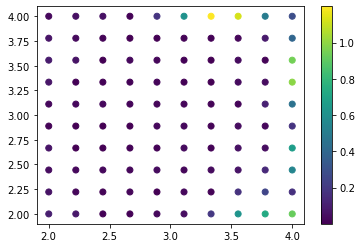

In [31]:
import matplotlib.pyplot as plt
actual_errors = np.diagonal(np.array(errors).reshape((params_test.shape[0], params_test.shape[0])))
plt.scatter(params_test[:, 0], params_test[:, 1], c=np.diagonal(np.array(errors).reshape((params_test.shape[0], params_test.shape[0]))))
plt.colorbar()
#plt.scatter(params_test[:, 0], params_test[:, 1], c=errors)
#plt.colorbar()

In [32]:
np.mean(actual_errors), np.median(actual_errors)

(0.13414818658286676, 0.026740732216774442)

In [ ]:
bigN = 10
#plt.scatter(params_test[np.argsort(actual_errors)[:bigN]][:, 0], params_test[np.argsort(actual_errors)[:bigN]][:, 1])
plt.scatter(params[chosen_parameter_indices][:, 0], params[chosen_parameter_indices][:, 1])
plt.show()

In [ ]:
np.median(errors), np.mean(errors), np.max(errors), np.min(errors)

In [ ]:
npsol = np.array(solutions)
npsol_test = np.array(solutions_test2)
for i in range(npsol.shape[1]):
    plt.clf()
    plt.hist(npsol[:, i])
    plt.show()
    plt.clf()
    plt.hist(npsol_test[:, i])
    plt.show()

In [ ]:
for i in range(2):
    plt.clf()
    plt.hist(x_data.detach().numpy()[:, i])
    plt.show()
    plt.clf()
    plt.hist(x_test.detach().numpy()[:, i])
    plt.show()

In [ ]:
for i in range(num_nets):
    plt.clf()
    plt.hist(y_data.detach().numpy()[:, i])
    plt.show()
    plt.clf()
    plt.hist(y_test.detach().numpy()[:, i])
    plt.show()

In [ ]:
aa = x_data.detach().numpy()
bb = y_data.detach().numpy()
for i in range(bb.shape[1]):
    plt.clf()
    plt.scatter(aa[:, 0], aa[:, 1], c=bb[:, i])
    plt.colorbar()
    plt.show()

In [ ]:
aa = x_test.detach().numpy()
bb = y_test.detach().numpy()
for i in range(bb.shape[1]):
    plt.clf()
    plt.scatter(aa[:, 0], aa[:, 1], c=bb[:, i])
    plt.colorbar()
    plt.show()

In [ ]:
for i in range(bb.shape[1]):
    print(np.max(bb[:, i]))

# Perhaps a problem with sum approximation of integral with too few samples???

In [ ]:
plt.scatter(params_test[:, 0], params_test[:, 1])

In [ ]:
plt.scatter(params[:, 0], params[:, 1])

In [ ]:
import matplotlib.pyplot as plt
# look at best thetas in parameter space
for i in range(thetas.shape[1]):
    plt.clf()
    plt.scatter(params_test[:, 0], params_test[:, 1], c=thetas_test[:, i])
    plt.colorbar()
    plt.show()

In [ ]:
for i in range(thetas.shape[1]):
    plt.clf()
    plt.scatter(params[:, 0], params[:, 1], c=thetas[:, i])
    plt.colorbar()
    plt.show()

In [ ]:
# plot together!
plt.clf()
for i in range(thetas.shape[1]):
    p0 = np.concatenate([params[:, 0], params_test[:, 0]])
    p1 = np.concatenate([params[:, 1], params_test[:, 1]])
    tc = np.concatenate([thetas[:, i], thetas_test[:, i]])
    plt.scatter(p0, p1, c=tc)
    plt.colorbar()
    plt.show()

In [ ]:
for i in range(thetas.shape[1]):
    plt.scatter(params[:, 0], params[:, 1], c=theta_net(x_data).detach().numpy()[:, i])
    plt.colorbar()
    plt.show()

In [ ]:
NonlinearityApprox2(torch.tensor(solutions[0]).float(), params[0]), nonlinear_terms[0, 0]

In [ ]:
import matplotlib.pyplot as plt

approximations = []
for p in params_test:
    reduced_problem.set_mu(tuple(p))
    solution = np.array(reduced_problem.solve().vector()[:]).reshape(-1)
    approx = NonlinearityApprox(solution, p)
    approximations.append(approx)

for component in range(approximations[0].shape[0]):
    idx = np.arange(params_test.shape[0])[(params_test[:, 0] > 2) & (params_test[:, 1] > 2)]
    plt.scatter(params_test[idx, 0], params_test[idx, 1], c=np.array(approximations)[idx, component])
    plt.colorbar()
    plt.show()

In [ ]:
nonlinear_terms_matching = []
for i in range(params.shape[0]):
    nonlinear_terms_matching.append(nonlinear_terms[i, i])
nonlinear_terms_matching = np.array(nonlinear_terms_matching)

for component in range(approximations[0].shape[0]):
    plt.scatter(params[:, 0], params[:, 1], c=np.array(nonlinear_terms_matching)[:, component])
    plt.colorbar()
    plt.show()

In [ ]:
for component in range(approximations[0].shape[0]):
    plt.scatter(params[:, 0], params[:, 1], c=np.abs((np.array(nonlinear_terms_matching)[:, component] - np.array(approximations)[:, component])/np.array(nonlinear_terms_matching)[:, component]))
    plt.colorbar()
    plt.show()
    errors = np.abs((np.array(nonlinear_terms_matching)[:, component] - np.array(approximations)[:, component])/np.array(nonlinear_terms_matching)[:, component])
    print(np.mean(errors), np.min(errors), np.median(errors), np.max(errors))

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(params[:, 0], params[:, 1])
plt.show()

In [ ]:
for i in range(nonlinear_terms_test.shape[0]):
    for j in range(nonlinear_terms_test.shape[1]):
        #print(nonlinear_terms_test[i, j])
        #print(NonlinearityApprox(solutions_test[j], params[i]))
        print(params[i], params_test[j],
              np.linalg.norm(nonlinear_terms_test[i, j] - NonlinearityApprox(solutions_test[j], params[i])),
              np.linalg.norm(nonlinear_terms_test[i, j] - NonlinearityApprox(solutions_test[j], params[i])) / np.linalg.norm(nonlinear_terms_test[i, j])
             )
    print("")

In [ ]:
ss = 0
for i in range(nonlinear_terms_test.shape[0]):
    s = 0
    for j in range(nonlinear_terms_test.shape[1]):
        s += np.linalg.norm(nonlinear_terms_test[i, j] - NonlinearityApprox(solutions_test[j], params[i]))
    print(s / nonlinear_terms_test.shape[1])
    ss += s
print("\n")
print(ss / nonlinear_terms_test.shape[0] / nonlinear_terms_test.shape[1])

In [ ]:
ss = 0
for i in range(nonlinear_terms_test.shape[0]):
    s = 0
    for j in range(nonlinear_terms_test.shape[1]):
        s += np.linalg.norm(nonlinear_terms_test[i, j] - NonlinearityApprox(solutions_test[j], params[i])) / np.linalg.norm(nonlinear_terms_test[i, j])
    print(s / nonlinear_terms_test.shape[1])
    ss += s
print("\n")
print(ss / nonlinear_terms_test.shape[0] / nonlinear_terms_test.shape[1])

In [ ]:
for i, mu in enumerate(reduction_method.testing_set):
    problem.set_mu(mu)
    solution = problem.solve()
    solution = np.array(problem._solution.vector()[:])
    
    operator_form = problem.assemble_operator('c')[0]
    theta = problem.compute_theta('c')
    problem._solution.vector()[:] = solution
    
    nonlinear_term_i = (theta * Basis_Matrix @ np.array(assemble(operator_form)[:]).reshape(-1, 1)).reshape(-1)
    nonlinear_term_approx_i = NonlinearityApprox(solutions_test[i], mu)
    
    print(np.linalg.norm(nonlinear_term_i - nonlinear_term_approx_i), np.linalg.norm(nonlinear_term_i - nonlinear_term_approx_i)/np.linalg.norm(nonlinear_term_i))

In [33]:
class Approx_PINN_Loss(Losses.RONN_Loss_Base):
    """
    PINN_Loss

    ronn: object of type RONN

    RETURNS: loss function loss_fn(parameters, reduced order coefficients)
    """
    def __init__(self, ronn, normalization=None, beta=1., mu=None):
        super(Approx_PINN_Loss, self).__init__(ronn, mu)
        self.operators = None
        self.proj_snapshots = None
        self.T0_idx = None
        self.normalization = normalization
        if self.normalization is None:
            self.normalization = IdentityNormalization()

        self.beta = beta

        # if time dependent, we need the neural net to compute time derivative
        self.time_dependent = False

    def name(self):
        return "Approx_PINN"

    def _compute_operators(self):
        self.operators_initialized = True

        #self.operators = self.ronn.get_operator_matrices(self.mu)
        self.operators = self.ronn.get_reduced_operator_matrices(self.mu)

        if not self.normalization.initialized:
            self.normalization(self.ronn.get_projected_snapshots())

    def set_mu(self, mu):
        self.mu = mu
        self.operators_initialized = False

    def __call__(self, **kwargs):
        pred = kwargs["prediction_no_snap"]
        if not self.operators_initialized:
            self._compute_operators()

        pred = self.normalization(pred.T, normalize=False).T

        ##### 1st equation in system #####
        res1 = 0.0

        # these two could be combined when both not None
        if 'f' in self.operators:
            res1 -= self.operators['f']
        if 'c' in self.operators:
            for i, mu in enumerate(kwargs["input_normalization"](kwargs["normalized_mu"], normalize=False)):                
                mu = np.array(mu)
                #sol = pred[i].detach().numpy().reshape(-1)
                #C = NonlinearityApprox(sol, mu).reshape(-1, 1)
                sol = pred[i].float()
                C = NonlinearityApprox2(sol, mu).view(-1, 1).double().detach()

                # set element of self.operators['c']
                #self.operators['c'][i] = torch.tensor(C).double()[None, :, :]
                self.operators['c'][i] = C[None, :, :]

            res1 += self.operators['c']
        
        if 'a' in self.operators:
            res1 += torch.matmul(self.operators['a'], pred[:, :, None].double())

        loss1 = torch.mean(torch.sum(res1**2, dim=1)) if type(res1) is not float else res1
        if self.ronn.problem.dirichlet_bc_are_homogeneous:
            boundary_condition_loss = 0
        else:
            boundary_condition_loss = torch.mean((pred[:, 0] - 1.)**2)

        self.value = loss1 + self.beta*boundary_condition_loss

        return self.value

    def reinitialize(self, mu):
        normalization = self.normalization
        beta = self.beta
        return Approx_PINN_Loss(self.ronn, normalization, beta, mu)

In [34]:
torch.manual_seed(42)

input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("Approx_PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Approx_PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = None

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000, print_every=1
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [35]:
pinn_trainer.train()

0:  |F(x)| = 1.39541; step 1
1:  |F(x)| = 0.217962; step 1
2:  |F(x)| = 0.00767066; step 1
3:  |F(x)| = 9.97118e-06; step 1
4:  |F(x)| = 1.68875e-11; step 1
scipy solver converged in 6 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


RuntimeError: The size of tensor a (6) must match the size of tensor b (4) at non-singleton dimension 0

In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$, $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$.

In [ ]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=False)

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = None

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000, print_every=1
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [ ]:
start = time.time()
pinn_trainer.train()
end = time.time()
print(end - start)

In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [ ]:
reduction_method.initialize_testing_set(50)
#reduction_method.error_analysis()

#### 4.6.2 PINN Error Analysis

In [ ]:
test_mu = torch.tensor(reduction_method.testing_set)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (5., 5.), input_normalization_pinn, output_normalization_pinn, colorbar=True
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (5., 5.), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (5., 5.), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, relative=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()